# Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important to get some practice working with the difficulties of these 

For this project, i will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#Setting the seed to assure you get the same results on each individual run
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [2]:
# Reading data into dataframe and show top few rows
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
# Number of rows
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
# Number of unique users
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
#Proportion of users converted
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
# The rows where the new_page and treatment don't match
messy_rows = df.loc[((df['group'] == 'treatment') & (df['landing_page'] != 'new_page')) | ((df['group'] != 'treatment') & (df['landing_page'] == 'new_page'))]
# The number of times
len(messy_rows)

3893

f. Do any of the rows have missing values?

In [7]:
# If there are rows have missing values?
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.

a.Drop messy data and store new dataframe in **df2**.

In [8]:
# Drop messy data and look at the new size
df2 = df.drop(messy_rows.index)
df2.shape[0]

290585

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below.

a. How many unique **user_id**s are in **df2**?

In [10]:
# Number of unique user_ids in df2?
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
# The user_id of repeated user in df2
repeated_user = df2[df2.user_id.duplicated()]
repeated_user.iloc[0,0]

773192

c. What is the row information for the repeat **user_id**? 

In [12]:
# Row information for the repeat user_id
repeated_user

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
# Drop duplicate then insure of result
df2.drop_duplicates('user_id', inplace=True)
df2.shape[0]

290584

`4.` Use **df2** in the cells below to answer the quiz:

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
# The probability of an individual converting regardless of the page they receive
conversion_prob = df2.converted.mean()
print('conversion_prob =',conversion_prob)

conversion_prob = 0.119597087245


b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
# The control conversion probability
control_conversion_prob = df2.query('group == "control"')['converted'].mean()
print('control_conversion_prob =',control_conversion_prob)

control_conversion_prob = 0.1203863045


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
# The treatment conversion probability
treatment_conversion_prob = df2.query('group == "treatment"')['converted'].mean()
print('treatment_conversion_prob =',treatment_conversion_prob)

treatment_conversion_prob = 0.118808065515


d. What is the probability that an individual received the new page?

In [17]:
# The new_page conversion probability
new_page_prob = (df2['landing_page'] == 'new_page').mean()
print('new_page_prob =',new_page_prob)

new_page_prob = 0.500061944223


In [18]:
# The difference between the treatment group and the control group conversion probabilities
diff = treatment_conversion_prob - control_conversion_prob
diff

-0.0015782389853555567

e. Consider results from parts (a) through (d) above, whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions?

> **Noted from the parts (a) through (d) above that about half (50%) of the users recieving the new page, and the total conversions probability is about 12% percent but the probability of an individual received the treatment is less mostly than the an individual received the control (0.0016 is the difference) or same as equal .. leading thaty they have the same probability of conversions, so there is no sufficient evidence to conclude that the new treatment page leads to more conversions.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Null:   $p_{new}$ - $p_{old}$  <=  0**

**Alternative:   $p_{new}$ - $p_{old}$  > 0**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
# The conversion rate for 𝑝𝑛𝑒𝑤 under the null
p_new = conversion_prob
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [20]:
# The conversion rate for  𝑝𝑜𝑙𝑑  under the null
p_old = conversion_prob
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [21]:
# The number of individuals in the treatment group
treatment_group = df2[df2['group'] == 'treatment']
n_new = treatment_group.shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [22]:
# The number of individuals in the control group
control_group = df2[df2['group'] == 'control']
n_old = control_group.shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
# n𝑛𝑒𝑤  transactions with a conversion rate of  p𝑛𝑒𝑤  under the null simulation
new_page_converted = np.random.choice(2, n_new, p=[1-p_new,p_new])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
# n𝑜𝑙𝑑  transactions with a conversion rate of  p𝑜𝑙𝑑  under the null simulation
old_page_converted = np.random.choice(2, n_old, p=[1-p_old,p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
# p𝑛𝑒𝑤  - p𝑜𝑙𝑑 for simulated values
sim_pdiff = new_page_converted.mean() - old_page_converted.mean()
sim_pdiff

-0.00028423329284120447

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [26]:
# Sampling distribution of 10000 iterations
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice(2, n_new, p=[1-p_new,p_new])
    old_page_converted = np.random.choice(2, n_old, p=[1-p_old,p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())
    
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what expected?

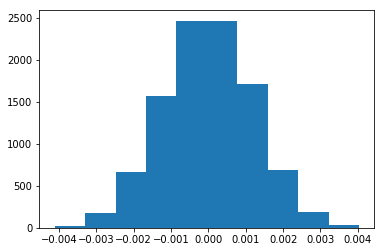

In [27]:
# Plot histogram of the sampling ditribution difference
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

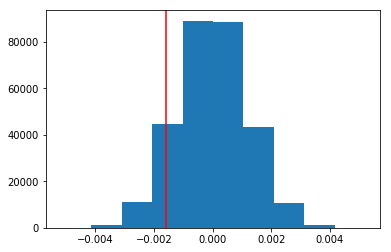

In [28]:
# Simulate the normal distribution of the null hypotheses
null_vals = np.random.normal(0, p_diffs.std(), df2.shape[0])
# Plot the histogram
plt.hist(null_vals);
# Show the value of difference
plt.axvline(diff, color='r');

In [29]:
# Calculate the p-value of our hypothesis
p_value = (null_vals > diff).mean()
p_value

0.90472290284392809

k. What you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

> **Note that the p_value is high (0.9) and much greater than type1 error (0.05), so we failed to reject null hypothesis means that the null hypothesis is true and there is no difference between the new and old pages**

l. We could also use a built-in to achieve similar results. Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [30]:
# Import statmodels.api 
import statsmodels.api as sm

# Calculate the convert_old, convert_old, n_old and n_new
convert_old = df2.query('group == "control" & converted == 1').shape[0]
convert_new = df2.query('group == "treatment" & converted == 1').shape[0]
n_old = df2.query('group == "control"').shape[0]
n_new = df2.query('group == "treatment"').shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


(17489, 17489, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [31]:
# Compute the test statistic and p-value using the built in
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger') 
z_score, p_value

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

> **Noted here that the p_values calculated from the tow different calculation ways (the A/B test and the built in ) are the same (0.9) which inforce our results that we failed to reject the null hypothesis of the evidence where there is no difference between new and old pages.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

> **Logistic Regression** is the best regression model to fit here

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [32]:
# Adding an intercept column
df2['intercept'] = 1

# Get tow dummies of landing page and drop it and one of the tow to get full rank with baseline columns
df2[['ab_page', 'other_page']] = pd.get_dummies(df2['landing_page'])
df2.drop(columns=['landing_page', 'other_page'], inplace=True)
df2.head()

,user_id,timestamp,group,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,1,1,0


c. Use **statsmodels** to instantiate the regression model on the two columns created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [33]:
# Fit a logistic regression model
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of the model below, and use it as necessary to answer the following questions.

In [34]:
 # The summary of model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 27 May 2019   Pseudo R-squ.:               8.077e-06
Time:                        18:08:39   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [35]:
# The exponential of parameters
np.exp(results.params)

intercept    0.136863
ab_page      0.985123
dtype: float64

In [36]:
# Compute 1/epx
1/np.exp(results.params)

intercept    7.306593
ab_page      1.015102
dtype: float64

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

> **The p-value associated with ab_page is 0.19 which is greater than the type1 err 0.05 and this give us the evidence of failling to reject the null hypothesis.
This P-value is not the same as p-value from the A/B test because of the difference in null & alternative hypotheses in the tow cases, meaning that here the null and alternative hypothesis is about 0.0 or 0.1 only and no prob value between them.**

f. Now, considering other things that might influence whether or not an individual converts.  It is a good idea to consider other factors to add into the regression model?  Are there any disadvantages to adding additional terms into your regression model?

> **If other factors that might influence whether or not an individual converts, we should consider to add it into our regression model to correct fit the model and get valid coffecionts, but in the same time adding it has disadvantages of chance of occurrence of Multi-collinearity, non-linearity, interaction or any multi-assumptions related potential problems.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. Will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: We will need two columns for the three dummy variables.** Will provide the statistical output as well as a written response to answer this question.

In [37]:
# Read countries data into a dataframe then joining it with our dataframe
countries = pd.read_csv('countries.csv')
df3 = df2.merge(countries, on='user_id', how='outer')

# Get 3 dummies of country column
df3[['CA', 'UK','US']] = pd.get_dummies(df3['country'])

# Drop the CA column to get a full rank with baseline of CA column
df3.drop(columns=['CA', 'country'], inplace=True)

# Fit a logistic regression model and show the summary
logit_mod = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'US', 'UK']])
results = logit_mod.fit()
results.summary()                           

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 27 May 2019   Pseudo R-squ.:               2.323e-05
Time:                        19:12:08   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

In [38]:
# The exponential of parameters
np.exp(results.params)

intercept    0.131332
ab_page      0.985168
US           1.041599
UK           1.051944
dtype: float64

> **Here we note that the p-value of the countries are greater than type1 err 0.05, and bigger coefs (bigger than ab_page coef), so we have the evidence of the countries has the big impact on conversions.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [39]:
# Adding the interactions metrics to data
df3['page_us'] = df3['ab_page']*df3['US']
df3['page_uk'] = df3['ab_page']*df3['UK']

# Fit a logistic regression model and show the summary
logit_mod = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'US', 'UK', 'page_us', 'page_uk']])
results = logit_mod.fit()
results.summary()                 


Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 27 May 2019   Pseudo R-squ.:               3.482e-05
Time:                        19:30:09   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
page_us        0.0469      0.054      0.872      0.383      -0.059       0.152
page_uk        0.0783      0.057      1.378      0.168      -0.033       0.190
==============================================================================
"""

In [41]:
# The exponential of parameters
np.exp(results.params)

intercept    0.134794
ab_page      0.934776
US           1.017682
UK           1.011854
page_us      1.048001
page_uk      1.081428
dtype: float64

> **now we note that the impact of interactions on results of our model, that when we neglected (not including) the interactions we get wrong ceofs and p-values.**

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  have reached the end of the A/B Test Results project!  And should be very proud of all you have accomplished!